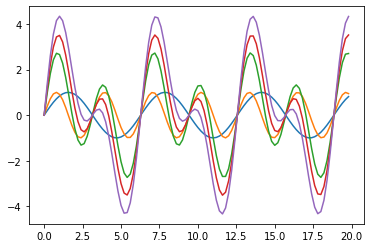

In [24]:
# -*- coding: utf-8 -*-
from typing import Dict
import numpy as np
from hyperstatic.common.curve import Curve
from hyperstatic.core.fe_model.load.pattern import LoadPattern
class LoadCase(object):
    def __init__(self,name:str):
        self.__name=name
        self.__base_case=None
        self.__pattern:Dict[str,LoadPattern]={} #to save pattern objects
        self.__load_factor:Dict[str,float]={} #to assign load factor
        self.__load_curve:Dict[str,np.array]={} #to assign load curve
        self.__restraint:Dict[str,np.array]={}

    @property
    def name(self):
        return self.__name

    def add_pattern(self,pattern:LoadPattern,factor:float):
        self.__pattern[pattern.name]=pattern
        self.__load_factor[pattern.name]=factor

    def add_pattern_time_history(self,pattern:LoadPattern,factor:float,curve:np.array):
        self.__pattern[pattern.name]=pattern
        self.__load_factor[pattern.name]=factor
        self.__load_curve[pattern.name]=curve

    def set_pattern_factor(self,name,factor):
        self.__load_factor[name]=factor

    def set_nodal_restraint(self,name:str,u1:bool,u2:bool,u3:bool,r1:bool,r2:bool,r3:bool):
        self.__restraint[name]=np.array([u1,u2,u3,r1,r2,r3])

    def get_nodal_restraint_dict(self):
        res={}
        for k,v in self.__restraint.items():
            res[k]=np.array(v)
        return res

    def get_nodal_f(self,name):
        fn=np.zeros(6)
        for patname,factor in self.__load_factor.items():
            pat=self.__pattern[patname]
            f=pat.get_nodal_f(name)
            if f is None:
                continue
            fn+=f*factor   
        return fn

    def get_nodal_f_time_history(self,name):
        max_length=0
        for patname,curve in self.__load_curve.items():
            l=curve.shape[1]
            max_length=max(l,max_length)

        fn=np.zeros((max_length,6))
        for patname in self.__load_factor.keys():
            pat=self.__pattern[patname]
            factor=self.__load_factor[patname]
            curve=self.__load_curve[patname]
            f=pat.get_nodal_f(name)
            if f is None:
                continue
            crv=curve[1,:]
            fn+=crv.reshape(crv.size,1).dot(f.reshape(1,6))*factor
        return fn

    def get_nodal_f_dict(self):
        res={}
        for patname,pat in self.__pattern.items():
            d=pat.get_nodal_f_dict()
            for node,load in d.items():
                if node in res.keys():
                    res[node]+=load*self.__load_factor[patname]
                else:
                    res[node]=np.zeros(6)
        return res

    def get_nodal_f_time_history_dict(self,name):
        max_length=0
        for patname,curve in self.__load_curve.keys():
            l=curve.shape[1]
            max_length=max(l,max_length)
        res={}
        for patname in self.__load_factor.keys():
            pat=self.__pattern[patname]
            factor=self.__load_factor[patname]
            curve=self.__load_curve[patname]
            d=pat.get_nodal_f_dict()
            for node,load in d.items():
                if node in res.keys():
                    crv=curve[1,:]
                    fn+=crv.reshape(crv.size,1).dot(f.reshape(1,6))*factor
                else:
                    res[node]=np.zeros((max_length,6))
        return res

    def get_nodal_d_dict(self):
        res={}
        for patname,pat in self.__pattern.items():
            d=pat.get_nodal_d_dict()
            for node,load in d.items():
                if node in res.keys():
                    res[node]+=load*self.__load_factor[patname]
                else:
                    res[node]=np.zeros(6)
        return res


    def get_beam_f(self,name,l):
        fe=np.zeros(12)
        for patname,factor in self.__load_factor.items():
            pat=self.__pattern[patname]
            f=pat.get_beam_f(name,l)
            if f is None:
                continue
            fe+=f*factor
        return fe

    def get_beam_f_dict(self,ldict):
        res={}
        for patname,pat in self.__pattern.items():
            d=pat.get_beam_f_dict(ldict)
            for beam,load in d.items():
                if beam in res.keys():
                    res[beam]+=load*self.__load_factor[patname]
                else:
                    res[beam]=np.zeros(6)
        return res

    def get_settings(self)->dict:
        raise NotImplementedError

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    
    lc=LoadCase("lc")
    lp1=LoadPattern("lp1")
    lp2=LoadPattern("lp2")
    lp1.set_nodal_load("1",1,1,1,0,0,0)
    lp2.set_nodal_load("1",2,2,2,0,0,0)
    lc.add_pattern(lp1,1)
    lc.add_pattern(lp2,2)
    f=lc.get_nodal_f("1")
    assert f[0]==5
    assert f[2]==5

    lc=LoadCase("lc")
    lp1=LoadPattern("lp1")
    lp2=LoadPattern("lp2")
    lp1.set_nodal_load("1",1,2,3,0,0,0)
    lp2.set_nodal_load("1",2,2,2,0,0,0)
    c1=Curve.sin("sine",1,1,0,0.2,100).to_array()
    c2=Curve.sin("sine",1,2,0,0.2,100).to_array()
    plt.plot(c1[0,:],c1[1,:])
    plt.plot(c2[0,:],c2[1,:])
    lc.add_pattern_time_history(lp1,1,c1)
    lc.add_pattern_time_history(lp2,1,c2)
    f=lc.get_nodal_f_time_history("1")
    plt.plot(c[0,:],f[:,0])
    plt.plot(c[0,:],f[:,1])
    plt.plot(c[0,:],f[:,2])
    assert f[10,2]==1.2142872898611885

2022-07-17 03:11:48,487|INFO|:solving problem with 6 DOFs...
2022-07-17 03:11:48,488|INFO|:solving problem with 6 DOFs...
2022-07-17 03:11:48,488|INFO|:Assembling K..
2022-07-17 03:11:48,491|INFO|:Assembling M..
2022-07-17 03:11:48,498|INFO|:Done!
2022-07-17 03:11:48,504|INFO|:Solving TIME-HISTORY case DTIcase using DIRECT TIME INTEGRATION
2022-07-17 03:11:48,505|INFO|:Assembling K..
2022-07-17 03:11:48,509|INFO|:Assembling M..


T= [1.58113427e+04 4.59339558e+03 1.05618999e+00]
0.3351032163829113 -0.0021220659078919368


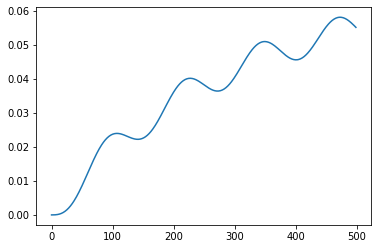

In [205]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 30 10:26:29 2016

@author: HZJ
"""
import os

import logging
import numpy as np
from scipy import linalg
from scipy import sparse as spr
import scipy.sparse.linalg as sl

from hyperstatic.core.fe_model.model import Model
from hyperstatic.core.fe_model.load.loadcase import ModalCase,TimeHistoryCase
from hyperstatic.core.fe_solver import Solver

class TimeHistorySolver(Solver):
    def __init__(self,workpath:str,filename:str):
        super().__init__(workpath,filename)

    @property
    def workpath(self):
        return super().workpath

    def solve(self,casename:str):
        assembly=super().assembly
        algo=assembly.get_loadcase_setting(casename)['algorithm']
        if algo=='direct_time_integration':
            self.solve_direct_time_integration(casename)
        elif algo=='modal_decomposition':
            self.solve_modal_decomposition()

    def solve_direct_time_integration(self,casename:str):
        assembly=super().assembly
        logging.info('Solving TIME-HISTORY case {} using DIRECT TIME INTEGRATION'.format(casename))
        setting=assembly.get_loadcase_setting(casename)
        dt=setting["params"]['step_size']
        damping=setting["params"]['damping_ratio']
        
        if setting['base_case']==None:
            base_case="0"
        
        path=os.path.join(self.workpath,base_case+'.k') #stiff matrix
        if os.path.exists(path):
            K=np.load(path)
        else:
            K=assembly.assemble_K()
            np.save(path,K)
        path=os.path.join(self.workpath,base_case+'.m') #mass matrix
        if os.path.exists(path):
            M=np.load(path)
        else:
            M=assembly.assemble_M()
            np.save(path,M)
            
        ########Reileigh Damping
        xi_i=0.05
        xi_j=0.02
        T_i=2.0
        T_j=1.0
        omega_i=2*np.pi/T_i
        omega_j=2*np.pi/T_j
        a0=2*omega_i*omega_j/(omega_j**2-omega_i**2)*(xi_i*omega_j-xi_j*omega_i)
        a1=2*omega_i*omega_j/(omega_j**2-omega_i**2)*(-xi_i/omega_j+xi_j/omega_i)
        C=(a0*M+a1*K).tocoo()
        print(a0,a1)
        

        K_=assembly.assemble_boundary(casename,K)
        M_=assembly.assemble_boundary(casename,M)
        C_=assembly.assemble_boundary(casename,C)

        u=np.zeros((2,K_.shape[0])) #-dt,0, row-first.
        v=np.zeros((2,K_.shape[0]))
        a=np.zeros((2,K_.shape[0]))
        c0=1/dt/dt
        c1=1/2/dt
        c2=2*c0
        c3=1/c2
        u[0,:]=u[1,:]-dt*v[1,:]+c3*a[1,:] #central diff
        M_hat=c0*M_+c1*C_
#         L,D,perm=linalg.ldl(M_hat)
        tmax,tmin=assembly.get_max_min_step(casename)
#         test=[]
        for t in range(tmin):
            f=assembly.assemble_f(casename,t)
            f_=assembly.assemble_boundary(casename,f)
            f_hat=(f_.reshape(1,6)-(K_-c2*M_).dot(u[-1,:])-(c0*M_-c1*C_).dot(u[-2,:])).reshape(6,1)
#             test.append(f_hat[2])
            d,info=sl.cgs(M_hat,f_hat)
            u=np.vstack([u,d])
            # v.append(c1*(-a[t-1]+a[t+1]))
            # a.append(c0*(a[t-1]-2*a[t]+a[t+1]))
#         plt.plot(test)
        path=os.path.join(self.workpath,casename+'.d')
        np.save(path,u[2:,:]) #neglect t=-1 and t=0
        return True

if __name__=='__main__':
    import sys
    from hyperstatic.core.fe_model.assembly import Assembly
    from hyperstatic.core.fe_model.model import Model
    from hyperstatic.core.fe_model.load.pattern import LoadPattern
    from hyperstatic.core.fe_model.load.loadcase import ModalCase
    from hyperstatic.core.fe_solver.dynamic import ModalSolver
    from hyperstatic.common.curve import Curve
    import matplotlib.pyplot as plt

    path="./test"
    if sys.platform=="win32":
        path="c:\\test"

    model=Model()
    model.add_node("1",0,0,0)
    model.add_node("2",1200,0,0)
    model.add_isotropic_material('steel',7849.0474,2e11,0.3,1.17e-5)
    model.add_beam_section_I('H400x200x20x30','steel',0.4,0.2,0.02,0.03)
    model.add_beam("A","1","2",'H400x200x20x30')
    model.set_nodal_restraint("1",True,True,True,True,True,True)
    model.set_nodal_mass("2",1,1,1,1,1,1)
    curve=Curve.sin('sine',A=10,w=5,phi=0,dt=0.01,n=500).to_array()
     
    eig=ModalCase("eigen")
    lc=TimeHistoryCase("DTIcase")
    lc.use_direct_time_integration(step_size=0.01,damping_ratio=0.02)
    patt=LoadPattern("patt1")
    patt.set_nodal_load("2",0,0,1000,0,0,0)
    lc.add_pattern(patt,1,curve)

    asb=Assembly(model,[eig,lc])
    asb.save(path,"test.asb")
    
    solver=ModalSolver(path,"test.asb")
    solver.solve("eigen")
    o2=np.load(os.path.join(path,"eigen.o.npy"))
    print("T=",2*np.pi/np.sqrt(o2))
    
    solver=TimeHistorySolver(path,"test.asb")
    solver.solve("DTIcase")
    d=np.load(os.path.join(path,"DTIcase.d.npy"))
    plt.plot(d[:,2])


In [87]:
d[:20,2].T

array([ 0.00000000e+00,  1.40965471e-03,  3.00046655e-03,  1.57128073e+02,
       -1.24935516e+07,  9.93451986e+11, -7.89964999e+16,  6.28157887e+21,
       -4.99493434e+26,  3.97183091e+31, -3.15828791e+36,  2.51138147e+41,
       -1.99697971e+46,  1.58794194e+51, -1.26268664e+56,  1.00405281e+61,
       -7.98394472e+65,  6.34860766e+70, -5.04823375e+75,  4.01421309e+80])

In [14]:
print(d[:,2])

[ 0.00000000e+000  1.90081844e-004  2.01316910e-004 -2.21715435e-002
 -2.36774292e-002  4.34401025e+006  4.60076939e+006 -1.10536369e+015
 -1.17069783e+015  2.81267504e+023  2.97892232e+023 -7.15704793e+031
 -7.58007570e+031  1.82116079e+040  1.92880315e+040 -4.63407073e+048
 -4.90797421e+048  1.17917164e+057  1.24886828e+057 -3.00048452e+065
 -3.17783249e+065  7.63494224e+073  8.08621651e+073 -1.94276434e+082
 -2.05759421e+082  4.94349943e+090  5.23569205e+090 -1.25790793e+099
 -1.33225837e+099  3.20083451e+107  3.39002439e+107 -8.14474678e+115
 -8.62615362e+115  2.07248766e+124  2.19498498e+124 -5.27358947e+132
 -5.58529244e+132  1.34190164e+141  1.42121663e+141  0.00000000e+000
  0.00000000e+000 -1.42120058e+141 -2.09134439e-004  0.00000000e+000
  1.42118453e+141  3.45705035e-005  0.00000000e+000 -1.42116848e+141
 -1.58965755e-004  0.00000000e+000  1.42115243e+141  9.58461409e-005
  0.00000000e+000 -1.42113637e+141 -9.20469272e-005  0.00000000e+000
  1.42112032e+141  1.62420693e-004